In [29]:
import numpy as np
import os
import shutil
import math
import time
import pinecone
from langchain.chains import ConversationalRetrievalChain, ConversationChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers.txt import TextParser
from langchain.memory import VectorStoreRetrieverMemory
from langchain.prompts import PromptTemplate
from langchain.text_splitter import Language, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Pinecone as PineconeVectorStore

Set up environment to have access to Pinecone and OpenAI

In [30]:
os.environ["OPENAI_API_KEY"] = ''
os.environ['PINECONE_API_KEY'] = ''

Initalize a pincone object

In [31]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key='')

Create indexes to store our data with diffenet sizes

In [32]:
# create an index in Pinecone storage
index_names = ["dataset-diff1", "dataset-diff2", "dataset-diff3", "dataset-diff4"]

for index_name in index_names:
    if index_name not in pc.list_indexes():
        pc.create_index(
            name=index_name,
            dimension=1536,  # Set to the dimension of OpenAI's ada-002 embeddings
            metric="euclidean", 
            spec=ServerlessSpec(
                cloud='aws', 
                region='us-east-1'
            )
        )

Initalize LLM and batch size for upserting to Pinecone Index 

In [33]:
# Path to the directory containing data with different sizes
data_source_path = "/Users/sihamargaw/Desktop/ReseachProject/Dataset/DD"

# LLM and question for retrieval
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Batch size for upserting vectors to Pinecone
batch_size = 245 # max records that can be added at once for vectors with 1536 dimension

# Store timing results for plotting
results = {
    "file_name": [],
    "embedding_time": [],
    "indexing_time": [],
    "retrieval_time": []
}

Data Preprocessing and Loading

In [34]:
documents_dict = {}
texts_dict = {}
metadata_dict = {}

for i, file_name in enumerate(os.listdir(data_source_path)):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(data_source_path, file_name)

        # Parse documents and split them into text chunks
        loader = PyPDFLoader(file_path)
        splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        documents = loader.load()
        documents = splitter.split_documents(documents)
        documents = [d for d in documents if len(d.page_content) > 5]
        texts = [d.page_content for d in documents]
        metadata = [d.metadata for d in documents]

        # Store the processed documents and texts for later use
        documents_dict[file_name] = documents
        texts_dict[file_name] = texts
        metadata_dict[file_name] = metadata
        print(f"Preprocessed {file_name}: {len(texts)} chunks.")

Preprocessed copy50.pdf: 199 chunks.
Preprocessed copy1000.pdf: 4784 chunks.
Preprocessed copy500.pdf: 1915 chunks.
Preprocessed copy200.pdf: 762 chunks.


Embedding Generation

In [35]:
embeddings_dict = {}

for file_name, texts in texts_dict.items():
    print(f"Generating embeddings for {file_name}...")
    t1 = time.time()
    embedding = OpenAIEmbeddings()
    text_embeddings = embedding.embed_documents(texts)
    t2 = time.time()
    embedding_time = t2 - t1
    embeddings_dict[file_name] = text_embeddings  # Store the embeddings
    print(f"Embeddings generated for {file_name} in {embedding_time} seconds")

    # Store the embedding generation time
    results["file_name"].append(file_name)
    results["embedding_time"].append(embedding_time)

Generating embeddings for copy50.pdf...
Embeddings generated for copy50.pdf in 1.217310905456543 seconds
Generating embeddings for copy1000.pdf...
Embeddings generated for copy1000.pdf in 32.88688898086548 seconds
Generating embeddings for copy500.pdf...
Embeddings generated for copy500.pdf in 13.26845097541809 seconds
Generating embeddings for copy200.pdf...
Embeddings generated for copy200.pdf in 5.620307922363281 seconds


Indexing in Pinecone

In [36]:
import concurrent.futures

# Assume embeddings_dict and index_names are predefined
for i, file_name in enumerate(embeddings_dict):
    text_embeddings = embeddings_dict[file_name]
    print(f"Indexing embeddings for {file_name} in index {index_names[i]}...")
    t3 = time.time()
    index_name = index_names[i]

    # Initialize the Pinecone index
    index = pc.Index(index_name)

    # Split the embeddings into batches
    num_batches = math.ceil(len(text_embeddings) / batch_size)

    # Prepare batch vectors
    batch_vectors_list = []
    for batch_num in range(num_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(text_embeddings))
        batch_vectors = [
            (str(j), text_embeddings[j], {"page_content": documents_dict[file_name][j].page_content})
            for j in range(start_idx, end_idx)
        ]
        batch_vectors_list.append(batch_vectors)

    # Use ThreadPoolExecutor for parallel upsert
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(lambda batch_vectors: index.upsert(vectors=batch_vectors), batch_vectors_list)

    t4 = time.time()
    indexing_time = t4 - t3
    print(f"Embeddings indexed for {file_name} in {indexing_time} seconds")

    # Store the indexing time for comparison
    results["indexing_time"].append(indexing_time)


Indexing embeddings for copy50.pdf in index dataset-diff1...
Embeddings indexed for copy50.pdf in 20.331908226013184 seconds
Indexing embeddings for copy1000.pdf in index dataset-diff2...
Embeddings indexed for copy1000.pdf in 442.1439371109009 seconds
Indexing embeddings for copy500.pdf in index dataset-diff3...
Embeddings indexed for copy500.pdf in 238.5673770904541 seconds
Indexing embeddings for copy200.pdf in index dataset-diff4...
Embeddings indexed for copy200.pdf in 90.88644099235535 seconds


Retrieval and Latency Measurement

In [37]:
embedding_model = OpenAIEmbeddings()  # Ensure this matches the model used for embedding
question = " How do AI researchers distinguish between human-like intelligence and rational intelligence? "

for i, file_name in enumerate(embeddings_dict):
    print(f"Retrieving data for {file_name}...")
    index_name = index_names[i]

    # Initialize the Pinecone index 
    pinecone_index = pc.Index(index_name)

    # Access the Pinecone index to perform retrieval (no embedding or indexing, just retrieval)
    retriever = PineconeVectorStore(
        index=pinecone_index,
        embedding=embedding_model,  # Reference the embedding model used during indexing
        text_key="page_content"  
    ).as_retriever(        
        search_type="similarity",
        search_kwargs={"k": 5},
    )
    
    # Use the retriever with LangChain's ConversationalRetrievalChain
    private_chatgpt = ConversationalRetrievalChain.from_llm(llm, retriever=retriever)

    start_time = time.time()
    response = private_chatgpt.run({'question': question, 'chat_history': ''})
    end_time = time.time()

    retrieval_time = end_time - start_time
    print(f"AI: {response}\n")
    print(f"Total retrieval time for {file_name}: {retrieval_time} seconds")

    # Store the retrieval time
    results["retrieval_time"].append(retrieval_time)

Retrieving data for copy50.pdf...
AI: AI researchers distinguish between human-like intelligence and rational intelligence based on two dimensions: human vs. rational and thought vs. behavior. Human-like intelligence focuses on mimicking human performance and internal thought processes, while rational intelligence is more abstract and aims to do the "right thing" based on formal definitions of intelligence. Some AI systems use machine learning methods to achieve competence, but not all AI systems do.

Total retrieval time for copy50.pdf: 2.0420069694519043 seconds
Retrieving data for copy1000.pdf...
AI: AI researchers distinguish between human-like intelligence and rational intelligence by considering two dimensions: human vs. rational and thought vs. behavior. Some researchers define intelligence based on fidelity to human performance, focusing on internal thought processes and reasoning. Others prefer an abstract, formal definition of intelligence called rationality, which involves d

In [41]:
%run TileDBPipeline.ipynb 

Preprocessed copy50.pdf: 199 chunks.
Preprocessed copy1000.pdf: 4784 chunks.
Preprocessed copy500.pdf: 1915 chunks.
Preprocessed copy200.pdf: 762 chunks.
Generating embeddings for copy50.pdf...
Embeddings generated for copy50.pdf in 1.4125611782073975 seconds
Generating embeddings for copy1000.pdf...
Embeddings generated for copy1000.pdf in 29.423845052719116 seconds
Generating embeddings for copy500.pdf...
Embeddings generated for copy500.pdf in 14.559390783309937 seconds
Generating embeddings for copy200.pdf...
Embeddings generated for copy200.pdf in 7.144726991653442 seconds
Indexing embeddings for copy50.pdf...
Embeddings indexed for copy50.pdf in 0.4850640296936035 seconds
Indexing embeddings for copy1000.pdf...
Embeddings indexed for copy1000.pdf in 0.7440330982208252 seconds
Indexing embeddings for copy500.pdf...
Embeddings indexed for copy500.pdf in 0.46062278747558594 seconds
Indexing embeddings for copy200.pdf...
Embeddings indexed for copy200.pdf in 0.34700798988342285 secon

Plotting

In [42]:
# Extract dataset sizes and corresponding times for Pinecone
pinecone_data = []
for i, fn in enumerate(results["file_name"]):
    dataset_size = int(fn.split("copy")[1].split(".")[0])  # Get the dataset size from the filename
    embedding_time = results["embedding_time"][i]  # Get the embedding time
    indexing_time = results["indexing_time"][i]    # Get the indexing time
    retrieval_time = results["retrieval_time"][i]  # Get the retrieval time
    pinecone_data.append((dataset_size, embedding_time, indexing_time, retrieval_time))  

# Sort by dataset size
pinecone_data.sort(key=lambda x: x[0])  # Sort based on dataset size

# Unzip sorted data
pinecone_sizes, pinecone_embedding_times, pinecone_indexing_times, pinecone_retrieval_times = zip(*pinecone_data)

# Extract and sort TileDB data similarly
tiledb_data = []
for i, fn in enumerate(resultsTileDB["file_name"]):
    dataset_size = int(fn.split("copy")[1].split(".")[0])  # Get the dataset size from the filename
    embedding_time = resultsTileDB["embedding_time"][i]  # Get the embedding time
    indexing_time = resultsTileDB["indexing_time"][i]    # Get the indexing time
    retrieval_time = resultsTileDB["retrieval_time"][i]  # Get the retrieval time
    tiledb_data.append((dataset_size, embedding_time, indexing_time, retrieval_time))  # Append the tuple

# Sort by dataset size
tiledb_data.sort(key=lambda x: x[0])  # Sort based on dataset size

# Unzip sorted TileDB data
tiledb_sizes, tiledb_embedding_times, tiledb_indexing_times, tiledb_retrieval_times = zip(*tiledb_data)

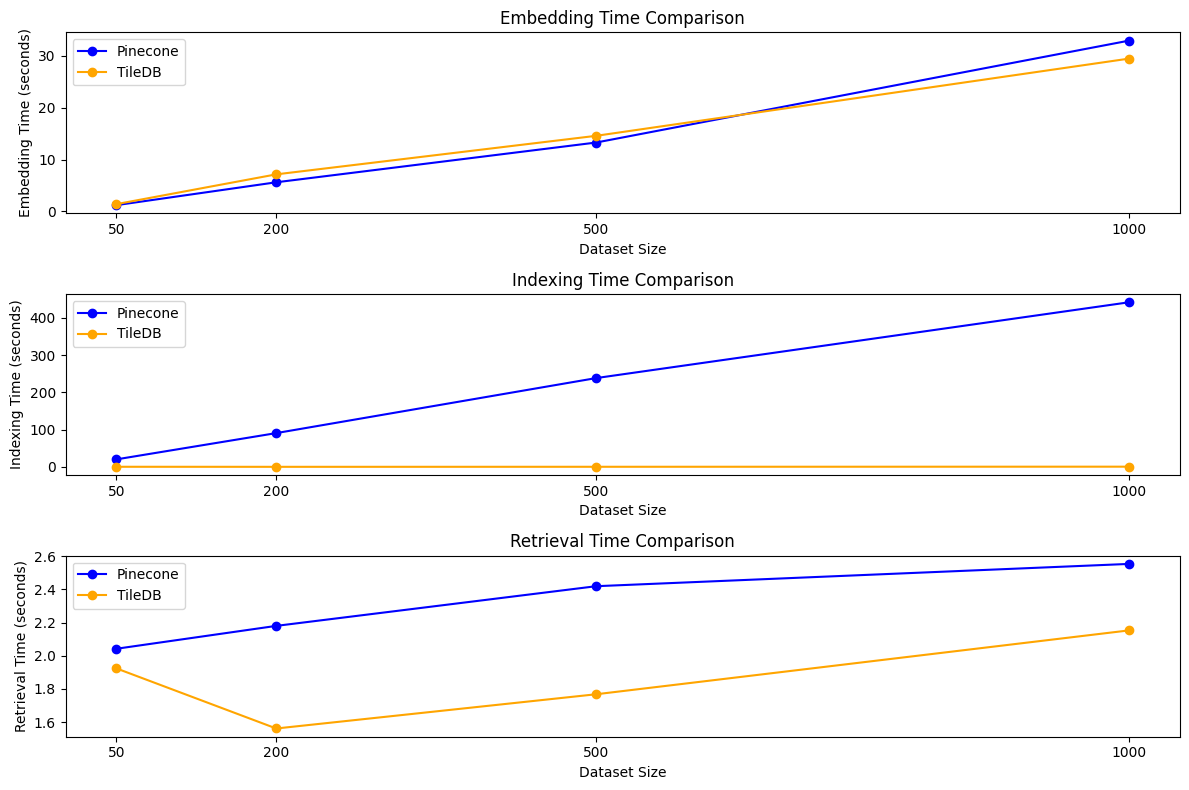

In [43]:
# Create the first plot: Embedding Time
plt.figure(figsize=(12, 8))

# Plot Embedding Time
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.plot(pinecone_sizes, pinecone_embedding_times, label='Pinecone', color='blue', marker='o')
plt.plot(tiledb_sizes, tiledb_embedding_times, label='TileDB', color='orange', marker='o')
plt.title('Embedding Time Comparison')
plt.xlabel('Dataset Size')
plt.ylabel('Embedding Time (seconds)')
plt.xticks(pinecone_sizes)  # Use pinecone_sizes for x-ticks
plt.legend(loc='upper left')

# Create the second plot: Indexing Time
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
plt.plot(pinecone_sizes, pinecone_indexing_times, label='Pinecone', color='blue', marker='o')
plt.plot(tiledb_sizes, tiledb_indexing_times, label='TileDB', color='orange', marker='o')
plt.title('Indexing Time Comparison')
plt.xlabel('Dataset Size')
plt.ylabel('Indexing Time (seconds)')
plt.xticks(pinecone_sizes)  # Use pinecone_sizes for x-ticks
plt.legend(loc='upper left')

# Create the third plot: Retrieval Time
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(pinecone_sizes, pinecone_retrieval_times, label='Pinecone', color='blue', marker='o')
plt.plot(tiledb_sizes, tiledb_retrieval_times, label='TileDB', color='orange', marker='o')
plt.title('Retrieval Time Comparison')
plt.xlabel('Dataset Size')
plt.ylabel('Retrieval Time (seconds)')
plt.xticks(pinecone_sizes)  # Use pinecone_sizes for x-ticks
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()
